In [18]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import multiprocessing

import pandas as pd
import datamol as dm
import numpy as np
import seaborn as sns

from molfeat.calc import RDKitDescriptors2D, FPCalculator, MordredDescriptors
from molfeat.trans import MoleculeTransformer, FPVecTransformer
from sklearn.preprocessing import OneHotEncoder

import collections.abc as collections
from molfeat.trans.concat import FeatConcat

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from src.config import mem
from src.utils import embed3d, embed_auto3d, eval_model, OffsetScaler, mol2smi, smi2mol
from src.descriptors import calc_dgl_feats, calc_hft_feats, calc_3d_feats, calc_2d_feats

from rdkit import RDLogger, Chem
RDLogger.DisableLog('rdApp.*')

train = dm.read_csv('../data/processed/train.csv', smiles_column='smi', index_col=0)
test = dm.read_csv('../data/processed/test.csv', smiles_column='smi', index_col=0)

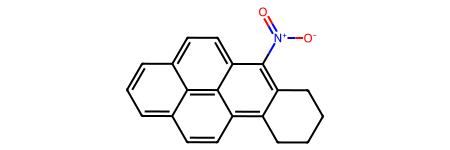

In [20]:
train.mol[0]

In [21]:
import molfeat
from molfeat.trans.fp import FPVecTransformer
from molfeat.trans.pretrained import PretrainedDGLTransformer
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer

ADD_3D_FEATS = True

feats2D_params = [
    # fps
    {'kind': 'ecfp:4', 'length': 1024},    
    {'kind': 'topological', 'length': 1024, 'n_jobs': -1},
    {'kind': 'avalon', 'length': 1024, 'n_jobs': -1},
    {'kind': 'layered', 'length': 1024, 'n_jobs': -1},
    {'kind': 'secfp', 'length': 1024, 'n_jobs': -1},
    {'kind': 'pattern', 'length': 1024},
    {'kind': 'pharm2D', 'length': 1024, 'n_jobs': -1},
    
    # fixed length fps
    {'kind': 'erg', 'n_jobs': -1},
    {'kind': 'maccs', 'n_jobs': -1},
    
    # fixed length descriptors - to normalize
    {'kind': 'estate', 'n_jobs': -1},
    {'kind': 'desc2D', 'n_jobs': -1},
    {'kind': 'mordred', 'n_jobs': -1},
    {'kind': 'cats2D', 'n_jobs': -1},
    {'kind': 'scaffoldkeys', 'n_jobs': -1},
    {'kind': 'skeys', 'n_jobs': -1},
]


feats3D_params = [
    {'kind': 'pharm3D', 'length': 1024, 'n_jobs': -1},
    {'kind': 'desc3D', 'n_jobs': -1},
    {'kind': 'cats3D', 'n_jobs': -1},
    {'kind': 'electroshape', 'n_jobs': -1},
    {'kind': 'usr',},
    {'kind': 'usrcat',},
]


dgl_params = [
    {'kind': 'gin_supervised_contextpred'},
    {'kind': 'gin_supervised_infomax'},
    {'kind': 'gin_supervised_edgepred'},
    {'kind': 'gin_supervised_masking'},
]

hf_params = [
    # {'kind': 'ChemBERTa-77M-MLM', 'random_seed': 42},
    {'kind': 'ChemBERTa-77M-MTR', 'random_seed': 42},
    # {'kind': 'ChemGPT-1.2B', 'random_seed': 42},
    {'kind': 'ChemGPT-19M', 'random_seed': 42},
    {'kind': 'ChemGPT-4.7M', 'random_seed': 42},
    {'kind': 'GPT2-Zinc480M-87M', 'random_seed': 42},
    # {'kind': 'MolT5', 'random_seed': 42},
    {'kind': 'Roberta-Zinc480M-102M', 'random_seed': 42},
]


# featurizer = FeatConcat(transformers, dtype=np.float32)

# # calcucalte feats and cache them
# for params in feats2D_params:
#     print(params)
#     mem.cache(calc_2d_feats, ignore=['n_jobs'])(train.smi, **params)
#     mem.cache(calc_2d_feats, ignore=['n_jobs'])(test.smi, **params)
# 
# for params in dgl_params:
#     print(params)
#     mem.cache(calc_dgl_feats)(train.smi, **params)
#     mem.cache(calc_dgl_feats)(test.smi, **params)
# 
# if ADD_3D_FEATS:
#     print('3D shape')
#     mem.cache(embed3d)(train.smi)
#     mem.cache(embed3d)(test.smi)
# 
#     for params in feats3D_params:
#         print(params)
#         mem.cache(calc_3d_feats)(train.smi, **params)
#         mem.cache(calc_3d_feats)(test.smi, **params)
    
# for params in hf_params:
#     feats = mem.cache(get_hft_predictions, ignore=['n_jobs', 'dtype', 'device'])(train.smi, params, device='cpu', n_jobs=-1)
    
# for kind, params in hft_params.items():
#     print('Initializing', end=' ')
#     trans = PretrainedHFTransformer(kind, **params, n_jobs=-1)
#     print(kind, end=' ')
#     feats = mem.cache(trans.transform)(train.smi)
#     print(feats.shape[1])

In [22]:
from tqdm import tqdm
from src.config import feats2D_params, feats3D_params, dgl_params, hf_params


def calc_all_features(smiles, inclue_3D=False):        
    def get_length(arr):
        for a in arr:
            if a is not None:
                return a.shape[0]        
    
    def feats_np_to_df(arr, params):
        length = get_length(arr)
        nan_arr = np.array([np.nan] * length)
        arr = [nan_arr if a is None else a for a in arr]  # fill None with numpy nan array
        arr = np.stack(arr)
        cols = [params['kind'] + '_' + str(i) for i in range(length)]
        return pd.DataFrame(arr, columns=cols, index=smiles.index)
                    
    df = pd.DataFrame(index=smiles.index)
    
    for params in tqdm(feats2D_params, desc='feats2D'):        
        arr = mem.cache(calc_2d_feats, ignore=['n_jobs'], verbose=False)(smiles, **params)
        # print(params['kind'], arr[1].shape)
        feats_df = feats_np_to_df(arr, params)    
        df = pd.concat([df, feats_df], axis=1)

    if inclue_3D:        
        mem.cache(embed3d)(smiles)
        for params in tqdm(feats3D_params, desc='feats3D'):
            arr = mem.cache(calc_3d_feats, verbose=False)(smiles, **params)            
            # print(params['kind'], arr[1].shape)
            feats_df = feats_np_to_df(arr, params)
            df = pd.concat([df, feats_df], axis=1)

        
    for params in tqdm(dgl_params, desc='dgl'):
        try:
            arr = mem.cache(calc_dgl_feats, verbose=False)(smiles, **params)
            feats_df = feats_np_to_df(arr, params)
            df = pd.concat([df, feats_df], axis=1)
        except:
            pass
    return df
                        
X_train = calc_all_features(train.smi, inclue_3D=True)

dgl: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


In [23]:
X_test = calc_all_features(test.smi, inclue_3D=True)

dgl: 100%|██████████| 4/4 [00:00<00:00, 19.12it/s]


In [24]:
X_train.shape, X_test.shape

((7939, 12907), (1221, 12907))

In [25]:
all_nan_cols = X_train.columns[X_train.isna().all()]
all_nan_cols

Index(['mordred_1049', 'mordred_1050', 'mordred_1051', 'mordred_1052',
       'mordred_1053', 'mordred_1054', 'mordred_1068', 'mordred_1070',
       'mordred_1075', 'mordred_1087', 'mordred_1088', 'mordred_1089',
       'mordred_1090', 'mordred_1091', 'mordred_1092', 'mordred_1103',
       'mordred_1104', 'mordred_1105', 'mordred_1106', 'mordred_1107',
       'mordred_1108', 'mordred_1109', 'mordred_1110', 'mordred_1111',
       'mordred_1112', 'mordred_1113', 'mordred_1114', 'mordred_1115',
       'mordred_1116', 'mordred_1117', 'mordred_1119', 'mordred_1120',
       'mordred_1121', 'mordred_1122', 'mordred_1124', 'mordred_1125',
       'mordred_1126', 'mordred_1127', 'mordred_1128', 'mordred_1129',
       'mordred_1130', 'mordred_1131', 'mordred_1132', 'mordred_1133',
       'mordred_1147', 'mordred_1149', 'mordred_1154', 'mordred_1166',
       'mordred_1167', 'mordred_1168', 'mordred_1169', 'mordred_1170',
       'mordred_1171', 'mordred_1182', 'mordred_1183', 'mordred_1184',
      

In [26]:
X_train.drop(columns=all_nan_cols, inplace=True)
X_test.drop(columns=all_nan_cols, inplace=True)

In [27]:
X_train.shape

(7939, 12831)

In [28]:
nan_cols = X_train.columns[X_train.isna().any()]
nan_cols

Index(['desc2D_11', 'desc2D_12', 'desc2D_13', 'desc2D_14', 'desc2D_18',
       'desc2D_19', 'desc2D_20', 'desc2D_21', 'desc2D_22', 'desc2D_23',
       ...
       'usrcat_50', 'usrcat_51', 'usrcat_52', 'usrcat_53', 'usrcat_54',
       'usrcat_55', 'usrcat_56', 'usrcat_57', 'usrcat_58', 'usrcat_59'],
      dtype='object', length=607)

In [29]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

In [30]:
X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

In [31]:
ohe = OneHotEncoder(sparse_output=False)

prop_df = pd.DataFrame(ohe.fit_transform(train[["prop"]]), index=train.index, columns=ohe.get_feature_names_out())
X_train = pd.concat([X_train, prop_df], axis=1)


prop_df = pd.DataFrame(ohe.transform(test[["prop"]]), index=test.index, columns=ohe.get_feature_names_out())
X_test = pd.concat([X_test, prop_df], axis=1)

X_train.shape, X_test.shape

((7939, 12834), (1221, 12834))

In [47]:
fps_list = ['ecfp:4', 'topological', 'avalon', 'layered', 'secfp', 'pattern', 'pharm2D', 'pharm3D', 'erg', 'maccs']
fps_cols = [c for c in X_train.columns if c.split('_')[0] in fps_list]
to_scale_cols = [c for c in X_train.columns if c not in fps_cols]
X_train[fps_cols].shape, X_train[to_scale_cols].shape
# X_train.columns

((7939, 8674), (7939, 4160))

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train.loc[:, to_scale_cols] = scaler.fit_transform(X_train[to_scale_cols])
X_test.loc[:, to_scale_cols] = scaler.transform(X_test[to_scale_cols])

In [50]:
X_train.loc[:, fps_cols] = X_train.loc[:, fps_cols].astype(np.uint8)
X_test.loc[:, fps_cols] = X_test.loc[:, fps_cols].astype(np.uint8)

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7939 entries, 0 to 7938
Columns: 12834 entries, ecfp:4_0 to prop_3
dtypes: float64(12834)
memory usage: 777.7 MB


In [52]:
X_train.columns

Index(['ecfp:4_0', 'ecfp:4_1', 'ecfp:4_2', 'ecfp:4_3', 'ecfp:4_4', 'ecfp:4_5',
       'ecfp:4_6', 'ecfp:4_7', 'ecfp:4_8', 'ecfp:4_9',
       ...
       'gin_supervised_masking_293', 'gin_supervised_masking_294',
       'gin_supervised_masking_295', 'gin_supervised_masking_296',
       'gin_supervised_masking_297', 'gin_supervised_masking_298',
       'gin_supervised_masking_299', 'prop_1', 'prop_2', 'prop_3'],
      dtype='object', length=12834)

In [33]:
X_train.to_pickle('../data/processed/X_train.pkl.zip')
X_test.to_pickle('../data/processed/X_test.pkl.zip')

In [35]:
train.target.to_pickle('../data/processed/y_target.pkl')

# Correlation

In [ ]:
from src.utils import get_fps_offset, get_fps_cols
from src.corr import non_corr_ids, get_corr, non_corr_features

fps_offset = get_fps_offset(X_train.columns)
descs_target = pd.concat([X_train.iloc[:, fps_offset:], y_train], axis=1)
corr = mem.cache(get_corr)(descs_target)

ids = non_corr_ids(corr, threshold=0.95)

In [ ]:
X_train.shape

In [ ]:
non_corr_features(X_train, y_train, threshold=0.95).shape

In [ ]:
print(len(corr.columns))
sns.heatmap(corr.abs());

In [ ]:
sns.heatmap(corr.iloc[ids, ids].abs());

In [ ]:
fps_cols = get_fps_cols(X_train.columns)
uncorr_cols = corr.columns[ids].tolist()

X_train_uncorr = X_train[fps_cols + uncorr_cols].copy()
X_train_uncorr.shape

In [ ]:
X_test_uncorr = X_test[fps_cols + uncorr_cols].copy()
X_test_uncorr.shape

In [ ]:
X_train_uncorr.to_pickle('../data/processed/X_train_uncorr.pkl.zip')
X_test_uncorr.to_pickle('../data/processed/X_test_uncorr.pkl.zip')

# full uncorrellated

In [ ]:
descs_target = pd.concat([X_train, y_train], axis=1)
corr = mem.cache(get_corr)(descs_target)

ids = non_corr_ids(corr, threshold=0.95)
uncorr_cols = corr.columns[ids].tolist()

len(uncorr_cols), X_train_uncorr.shape[1]

In [ ]:
# X_train_uncorr_all = X_train[uncorr_cols].copy()
# X_test_uncorr_all = X_test[uncorr_cols].copy()

In [ ]:
# X_train_uncorr_all.shape

In [ ]:
# X_train_uncorr_all.to_pickle('../data/processed/X_train_uncorr_all.pkl.zip')
# X_test_uncorr_all.to_pickle('../data/processed/X_test_uncorr_all.pkl.zip')

In [ ]:
# len(fps_cols), len(get_fps_cols(X_train_uncorr_all.columns))